In [2]:
import numpy as np
from scipy.ndimage import gaussian_filter1d
from nltools.external import glover_hrf
hrf_weight = glover_hrf(tr=1, oversampling=1)

response_time = np.load('/DATA/FilmMemory/Behavioral_analysis/mrbean_aha_moment.npy')
response_timeframe = np.zeros(610)
for i in response_time:
    response_timeframe[int(i)] += 1
response_time_mean = gaussian_filter1d(response_timeframe, 6, mode='constant')
response_time_convolved = np.convolve(response_time_mean, hrf_weight, mode='full')[:610]

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.linalg import lstsq
from scipy.stats import zscore
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr, spearmanr
import nibabel as nib
from scipy.stats import linregress
import pickle

BERT_NSP_matrix = np.load('data/BERT_NSP_results.npy')
semantic_similarity_matrix = np.zeros((3,300,300))
for i in range(3):
    annotation_embedding = np.load(f'data/sentence_embedding_{i+1:02d}.npy')
    semantic_similarity_matrix[i,:,:] = np.corrcoef(annotation_embedding)

BERT_NSP_matrix_wo_similarity = np.zeros((3,300,300))
for i in range(3):
    semantic_similarity_vector = semantic_similarity_matrix[i,:,:].reshape(-1,1)
    NSP_vector = BERT_NSP_matrix[i,:,:].reshape(-1,1)

    X = np.concatenate([semantic_similarity_vector, np.ones(semantic_similarity_vector.shape)], axis=1)

    coef, residual, _, _ = lstsq(X, NSP_vector)
    nsp_vector_clean = NSP_vector - X.dot(coef)
    BERT_NSP_matrix_wo_similarity[i,:,:] = nsp_vector_clean.reshape((300,300))

BERT_NSP_matrix_wo_similarity = np.mean(BERT_NSP_matrix_wo_similarity, axis=0)
BERT_NSP_matrix_wo_similarity_for_plotting = np.copy(BERT_NSP_matrix_wo_similarity)
BERT_NSP_matrix_wo_similarity_for_plotting[np.tril_indices(300)] = np.nan
BERT_NSP_matrix_wo_similarity = np.repeat(np.repeat(BERT_NSP_matrix_wo_similarity, 2, axis=0), 2, axis=1)

BERT_retrieval = np.zeros(600)
BERT_retrieval_target = np.zeros(600)
for i in range(1, 600):
    BERT_retrieval[i] = np.max(BERT_NSP_matrix_wo_similarity[:i,i]) #/ (i+1)
    BERT_retrieval_target[i] = np.argmax(BERT_NSP_matrix_wo_similarity[:i,i]) #/ (i+1)

BERT_retrieval_nohrf = np.copy(BERT_retrieval)
BERT_retrieval = np.convolve(BERT_retrieval, hrf_weight)[:610]

In [4]:
BERT_NSP_matrix = np.load('data/BERT_NSP_results.npy')

BERT_NSP_matrix_w_similarity = np.mean(BERT_NSP_matrix, axis=0)
BERT_NSP_matrix_w_similarity = np.repeat(np.repeat(BERT_NSP_matrix_w_similarity, 2, axis=0), 2, axis=1)

BERT_retrieval_w_similarity = np.zeros(600)
for i in range(1, 600):
    BERT_retrieval_w_similarity[i] = np.max(BERT_NSP_matrix_w_similarity[:i,i]) #/ (i+1)
BERT_retrieval_w_similarity = np.convolve(BERT_retrieval_w_similarity, hrf_weight)[:610]

In [5]:
similarity_matrix = np.zeros((3,300,300))
for i in range(3):
    annotation_embedding = np.load(f'data/sentence_embedding_{i+1:02d}.npy')
    similarity_matrix[i,:,:] = np.corrcoef(annotation_embedding)
similarity_matrix = np.mean(similarity_matrix, axis=0)

similarity_matrix = np.repeat(np.repeat(similarity_matrix, 2, axis=0), 2, axis=1)

similarity_retrieval = np.zeros(600)
for i in range(1, 600):
    similarity_retrieval[i] = np.max(similarity_matrix[:i,i]) #/ (i+1)

from nltools.external import glover_hrf
hrf_weight = glover_hrf(tr=1, oversampling=1)
similarity_retrieval = np.convolve(similarity_retrieval, hrf_weight)[:610]

/tmp/ipykernel_23218/2383686528.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(["", "", ""])


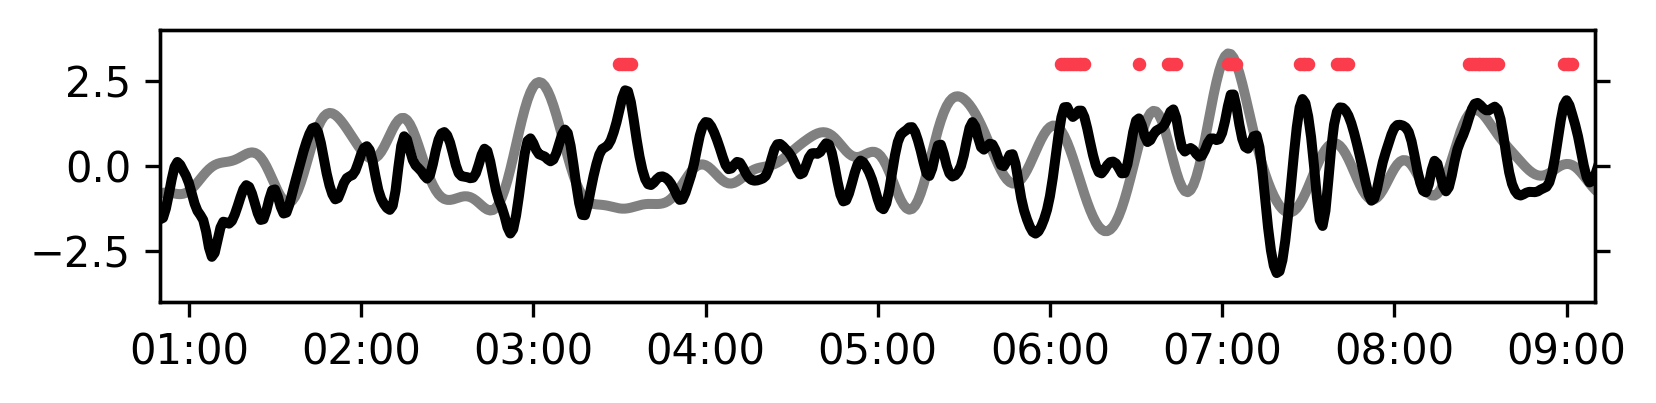

In [82]:
def get_timeformat(seconds):
    m, s = divmod(seconds, 60)
    string = f'{m:02d}:{s:02d}'
    return string

fig, ax1 = plt.subplots(figsize=(5.5,1.5), dpi=300)
x_indices = np.arange(0,610)[30:570]
ax1.plot(x_indices, zscore(response_time_convolved[x_indices]), lw=2.4, c='#808080')
ax2 = ax1.twinx()
ax2.plot(x_indices, zscore(BERT_retrieval[x_indices]), c='k', lw=2.4,)

ax1.set_xticks(np.arange(0,610,60),[get_timeformat(s) for s in np.arange(0,610,60)])
for i in np.argsort(BERT_retrieval)[::-1][:50]:
    ax1.scatter(i, 3.0, s=5, c='#fa3c4c', zorder=100)

ax1.set_ylim(-4,4)
ax2.set_ylim(-4,4)
ax2.set_yticklabels(["", "", ""])
ax1.set_xlim(50, 550)
fig.tight_layout() 
plt.show()

In [75]:
n_permutation = 1000

np.random.seed(0)

y = response_time_convolved[x_indices]
x_1 = BERT_retrieval[x_indices]
x_2 = BERT_retrieval_w_similarity[x_indices]
x_3 =similarity_retrieval[x_indices]
r_true_x1 = pearsonr(y, x_1)[0]
r_true_x2 = pearsonr(y, x_2)[0]
r_true_x3 = pearsonr(y, x_3)[0]
r_random_x1 = []
r_random_x2 = []
r_random_x3 = []
for i in range(n_permutation):
    response_time_shifted = np.roll(np.copy(response_time_mean), np.random.randint(0,610))
    response_time_shifted_convolved = np.convolve(response_time_shifted, hrf_weight, mode='full')[:610][x_indices]
    r_x1 = pearsonr(response_time_shifted_convolved, x_1)[0]
    r_random_x1.append(r_x1)
    r_x2 = pearsonr(response_time_shifted_convolved, x_2)[0]
    r_random_x2.append(r_x2)
    r_x3 = pearsonr(response_time_shifted_convolved, x_3)[0]
    r_random_x3.append(r_x3)
r_random_x1 = np.array(r_random_x1)
r_random_x2 = np.array(r_random_x2)
r_random_x3 = np.array(r_random_x3)

In [76]:
print((1+np.sum(r_random_x1>=r_true_x1))/(1+n_permutation))
print((1+np.sum(r_random_x2>=r_true_x2))/(1+n_permutation))
print((1+np.sum(r_random_x3>=r_true_x3))/(1+n_permutation))

0.00999000999000999
0.025974025974025976
0.42857142857142855


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


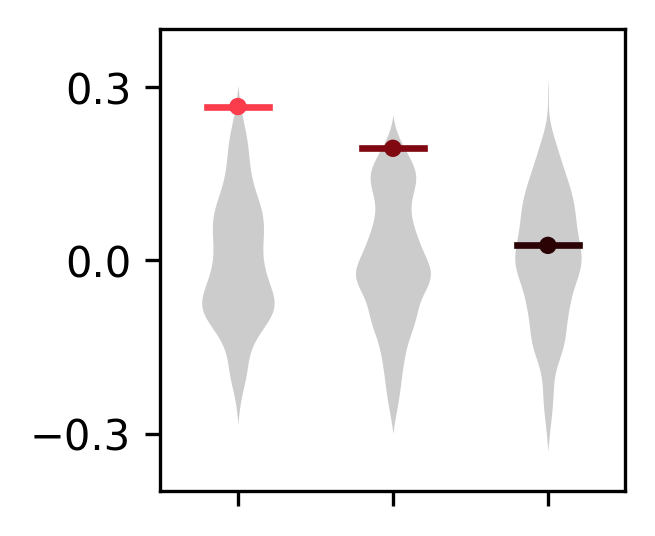

In [77]:
import pandas as pd
from matplotlib.collections import PolyCollection
from matplotlib.markers import MarkerStyle

def patch_violinplot():
     for art in ax.get_children():
          if isinstance(art, PolyCollection):
              art.set_edgecolor((1.0, 1.0, 1.0))
                  
df = pd.DataFrame(data={'null':np.hstack([r_random_x1, r_random_x2, r_random_x3]),
                        'moments':np.hstack([["x1"]*1000 + ['x2']*1000 + ['x3']*1000])})

import seaborn as sns
plt.style.use('default')
color_palette = sns.color_palette("crest", 10)

fig, ax = plt.subplots(1, 1, figsize=(2,2), dpi=300, sharex=True, sharey=True)
width = 0.22
offset2 = 0.01
x = np.arange(3)

#color_list= [[0.2,0.2,0.2], [60/255,84/255,136/255]]*3
color_list= [0.0,0.0,0.0,0.2]
offset = 0.2
sns.violinplot(data=df, x='moments', y='null',
               ax=ax, width=0.5, inner=None, color="#777777",
               points=100, showmeans=False, showextrema=False, showmedians=False, linewidth=0.6, zorder=1)
for i, v in enumerate(ax.findobj(PolyCollection)):
    v.set_facecolor(color_list)
color=['#fa3c4c', '#800811', '#2b0305']
ax.scatter([0,1,2], [r_true_x1, r_true_x2, r_true_x3], s=10, c=['#fa3c4c', '#800811', '#2b0305'])
ax.plot([0-offset,0+offset], [r_true_x1, r_true_x1], c='#fa3c4c', lw=1.6)
ax.plot([1-offset,1+offset], [r_true_x2, r_true_x2], c='#800811', lw=1.6)
ax.plot([2-offset,2+offset], [r_true_x3, r_true_x3], c='#2b0305', lw=1.6)

patch_violinplot()
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_xticklabels([])
ax.set_ylim(-0.4, 0.4)
ax.legend().set_visible(False)
ax.set_yticks([-0.3, 0.0, 0.3])

plt.xlim(-0.5,2.5)
plt.subplots_adjust(hspace=0.08)
plt.show()